## MNIST MLP (Keras + Tensorflow)

Comparison of Deep Shapley propagation with
- Gradient * Input
- Integrated Gradients
- DeepLIFT (Rescale and RevealCancel)
- Simple occlusion

### Get started
Assuming you have Keras > 2.2 and Tensorflow > 1.10, you will need the following libraries for comparison
- Install **DeepExplain**
https://github.com/marcoancona/DeepExplain
- Install **DeepLIFT**
https://github.com/kundajelab/deeplift
- Install **SHAP**
https://github.com/slundberg/shap

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('../..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy
print ("Using TF:", tf.__version__)
print ("Using Keras:", keras.__version__)

from dasp import DASP


# Import DeepLift
# Installation instructions: https://github.com/kundajelab/deeplift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

# Import Deep Explain (for Grad * Input, Integrated Gradients and Occlusion implementations)
# Installation instructions: https://github.com/marcoancona/DeepExplain
from deepexplain.tensorflow import DeepExplain

# Import DeepLift
# Installation instructions: https://github.com/slundberg/shap
import shap

Using TensorFlow backend.


Using TF: 1.10.1
Using Keras: 2.2.0


In [3]:
# Build and train a network.

SKIP_TRAIN = True
saved_model_file = '.model.h5'
saved_model_weights_file = '.model_weights.h5'

batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])

x_train = x_train.reshape(-1, img_rows*img_cols)
x_test = x_test.reshape(-1, img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    model = Sequential()
    model.add(Dense(256, input_shape=(img_rows*img_cols,), activation='relu', name='dense_1'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, name='dense_3'))
    model.add(Activation('softmax'))
    # ^ IMPORTANT: notice that the final softmax must be in its own layer 
    # if we want to target pre-softmax units

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)
    
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Test loss: 0.20852478792145848
Test accuracy: 0.9366


### Define a subset of the test set to generate explanations for

In [4]:
xs = x_test[0:2]
ys = y_test[0:2]

a_gradin = np.zeros_like(xs)
a_intgrad = np.zeros_like(xs)
a_res = np.zeros_like(xs)
a_rc = np.zeros_like(xs)
a_occlusion = np.zeros_like(xs)
a_shap = np.zeros_like(xs)
a_exact = np.zeros_like(xs)
a_shaplud = np.zeros_like(xs)
a_sampling = np.zeros_like(xs)

In [5]:
reduced_model = Model(model.inputs, model.layers[-2].output)
dasp = DASP(reduced_model)
shapley = dasp.run(xs)

relu
Tensor("dense_1_1/stack:0", shape=(?, 256, 4), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784, 2)            0         
_________________________________________________________________
dense_1 (LPDense)            (None, 256, 2)            200960    
_________________________________________________________________
dense_2 (LPDense)            (None, 128, 2)            32896     
_________________________________________________________________
dense_3 (LPDense)            (None, 10, 2)             1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Tensor("dense_1_1/stack:0", shape=(?, 256, 4), dtype=float32)
Tensor("lambda_1/strided_slice:0", shape=(?, 256, 2), dtype=float32)
______________________________________________________________________

In [ ]:
shapley = dasp.run(xs, 16)

In [6]:
a_shap = np.array([shapley[i, c, :] for i, c in enumerate(np.argmax(ys, 1))])
print (a_shap.shape)
print (a_shap[0])

(2, 784)
[-3.04721463e-02 -3.18157338e-02 -9.78337880e-03 -7.58767594e-03
 -8.91571771e-03  6.79771826e-02  5.14253415e-02 -5.13846241e-02
  4.31098267e-02  1.18186073e-02  3.32920402e-02  3.22880298e-02
 -3.83777432e-02  9.30087641e-03 -1.46064192e-01  3.33300121e-02
 -7.11683482e-02 -4.54572476e-02 -9.59701017e-02  5.85612766e-02
 -3.34601589e-02 -5.17016910e-02 -1.89978443e-02  1.39209442e-02
 -3.04342248e-02 -2.81441025e-02 -1.24987058e-01  3.40360031e-02
 -1.26648042e-03 -4.20509316e-02 -3.11257895e-02 -2.73446739e-02
 -3.29473950e-02  1.87227428e-02 -3.15301530e-02 -4.44226377e-02
 -1.11240588e-01 -3.46591026e-02  7.39871338e-03  3.65099311e-02
 -7.23475739e-02 -7.60901496e-02 -6.77492023e-02  1.55608337e-02
  1.36270495e-02  1.37698334e-02  6.46729469e-02 -4.91015464e-02
 -5.80902724e-03 -8.66356641e-02 -2.72621568e-02  1.90136693e-02
 -3.06685846e-02  2.25821268e-02  1.26642501e-02 -1.02970086e-01
 -4.13240958e-03  1.92699267e-03 -1.11515366e-03 -1.74535066e-02
 -8.99100006e-02

In [5]:
%%time

# Create an equivalent probabilistic model.
probInput = Input(shape=xs.shape[1:])
playerMask = Input(shape=xs.shape[1:])
coalitionSize = Input(shape=(1,))

probInput = Input(shape=xs.shape[1:])
y = ProbDenseInput(256, activation='relu', name='dense_1')([probInput, playerMask, coalitionSize])
y = ProbDense(128, activation='relu', name='dense_2')(y)
y = ProbDense(num_classes, name='dense_3')(y)
probModel = Model(inputs=[probInput, playerMask, coalitionSize], outputs=y)
# ... and load weights in it
probModel.load_weights(saved_model_weights_file, by_name=True)

# Implement loop to estimate shapley values
# Params
xn = 30

# Prepare array for output
result = np.zeros(xs.shape + (10,))
# Count how many input features are there
n_input_feat = xs.shape[1]
# Define sub-coalition sizes
Ks = range (0, n_input_feat, max(1, n_input_feat//xn))
print (list(Ks))

# Prepare array for output
result = np.zeros((xs.shape[0], xs.shape[1], 10))
# Define sub-coalition sizes
Ks = range (0, n_input_feat, max(1, n_input_feat // xn))

for j in range(n_input_feat):
    for ki in range(len(Ks)):
        # Define coalition size
        k = Ks[ki]
        #print (k)
        # Compute mask where 0 indicate the current player being tested
        _mask = np.ones_like(xs)
        _mask[:, j] = 0.0
        
        # Workaround: Keras does not seem to support scalar inputs
        _k = np.array([[k]]*len(xs))
        
        Y = probModel.predict([xs, _mask, _k])
        
        # Compute Shapley Values as mean of all coalition sizes
        result[:, j, :] += ((Y[..., 2] - Y[..., 0]) / len(Ks))
# Extract only the attribution for the correct class according to GT
a_shap = np.array([result[i, :, c] for i, c in enumerate(np.argmax(ys, 1))])
a_shap = a_shap.reshape(xs.shape)
print ('Done')

relu
relu
linear
[0, 26, 52, 78, 104, 130, 156, 182, 208, 234, 260, 286, 312, 338, 364, 390, 416, 442, 468, 494, 520, 546, 572, 598, 624, 650, 676, 702, 728, 754, 780]
Done
CPU times: user 48.7 s, sys: 3.65 s, total: 52.4 s
Wall time: 36.8 s


In [8]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    a_occlusion = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "occlusion" explanation method (6)
Model with multiple inputs:  False
Input shape: (784,); window_shape (1,); step 1
Done
CPU times: user 880 ms, sys: 64 ms, total: 944 ms
Wall time: 703 ms


In [7]:
%%time
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
CPU times: user 7.05 s, sys: 140 ms, total: 7.19 s
Wall time: 7.07 s


In [8]:
%%time

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
background = np.zeros_like(background)

# explain predictions of the model on four images
e = shap.DeepExplainer((model.layers[0].input, model.layers[-2].output), background)
shap_values = e.shap_values(xs)
#shap.image_plot(shap_values, -xs)
a_shaplud = [shap_values[idx][i] for i, idx in enumerate(np.argmax(ys, 1))]

CPU times: user 1.24 s, sys: 44 ms, total: 1.28 s
Wall time: 1.21 s


### Use Monte Carlo sampling to estimate the Shapley Values 
**Warn: it might take some time**

In [9]:
%%time
from utils.shapley_sampling import run_shapley_sampling
a_sampling = run_shapley_sampling(fModel, xs, ys)

CPU times: user 7min 36s, sys: 34.8 s, total: 8min 11s
Wall time: 5min 39s


#### Plot some heatmaps from the different methods

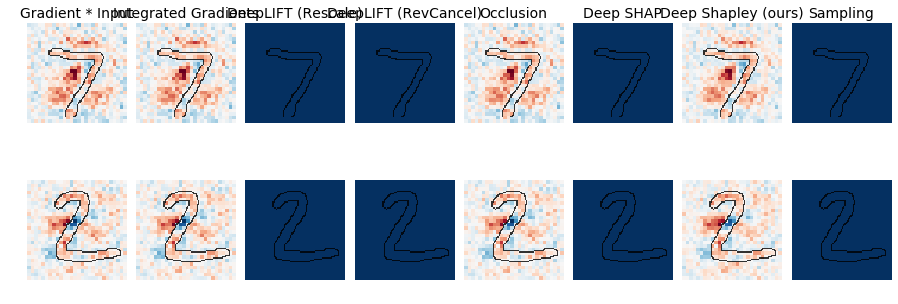

In [9]:
# Plot attributions
%matplotlib inline
from utils.utils import plot_attribution_maps

attributions = [a_gradin, a_intgrad, a_res, a_rc, a_occlusion, a_shaplud, a_shap, a_sampling]
names = ['Gradient * Input', 'Integrated Gradients', 'DeepLIFT (Rescale)',
         'DeepLIFT (RevCancel)', 'Occlusion', 'Deep SHAP', 'Deep Shapley (ours)', 'Sampling']

# Fix shape of attributions
shape = (xs.shape[0], img_rows,img_cols, 1)
attributions = [np.array(a).reshape(shape) for a in attributions]
xs_input = xs.reshape(shape)
# Plot all
plot_attribution_maps('test_mnist', xs_input, attributions, names, idxs=[0, 1])

#### Compare mean absolute error and Kendall tau correlation

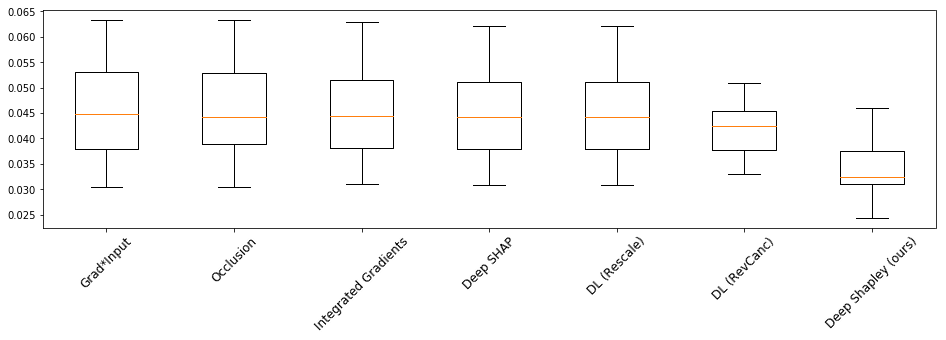

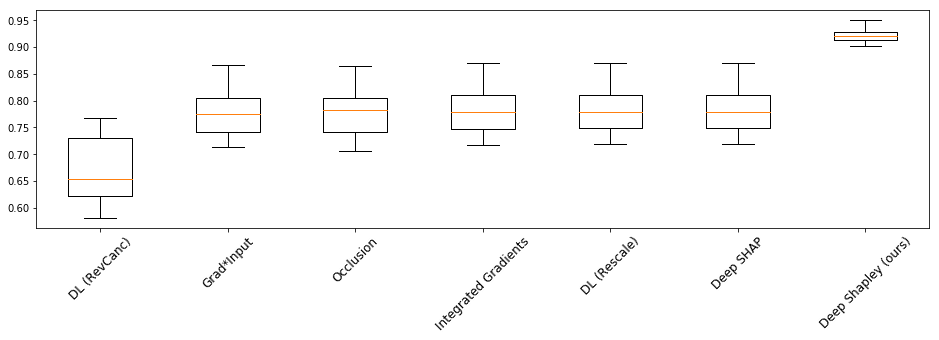

In [11]:
from utils.utils import plot_mae_comparison, plot_kendall_comparison
methods = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_shaplud, a_occlusion, a_sampling]
method_names = ['Grad*Input', 'Integrated Gradients', 'DL (Rescale)', 'DL (RevCanc)', 'Deep Shapley (ours)', 'Deep SHAP', 'Occlusion', 'Sampling']

plot_mae_comparison(methods, method_names, gt_idx=-1)
plot_kendall_comparison(methods, method_names, gt_idx=-1)

In [12]:
# Randomization test
original_attribution = a_shap
heatmaps = []
the_model = probModel
original_weights = {}
attribute_f = compute_deepshap

plt.figure()
plot(original_attribution[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Original')

for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        original_weights[i] = l.get_weights()
        # Replace weights with random
        new_weights = [np.random.normal(size=w.shape) for w in l.get_weights()]
        l.set_weights(new_weights)
        print (i, l)
        a = attribute_f()
        plt.figure()
        plot(a[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title(str(i))
        heatmaps.append(a)
        
        
# Restore weights
for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        l.set_weights(original_weights[i])

print ("Correlations")
for attr in heatmaps:
    corr = np.mean([scipy.stats.spearmanr(x.flatten(), y.flatten())[0] for x,y in zip(original_attribution, attr)])
    print (corr)

NameError: name 'compute_deepshap' is not defined

In [ ]:
# Randomization test
import matplotlib.pyplot as plt
from utils.utils import plot

original_attribution = a_intgrad
heatmaps = []
the_model = fModel
original_weights = {}
print (original_attribution.shape)
idx=1
plt.figure()
plot(original_attribution[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Original')

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    for i, l in enumerate(the_model.layers[::-1]):
        if (len(l.get_weights())):
            original_weights[i] = l.get_weights()
            # Replace weights with random
            new_weights = [np.random.normal(size=w.shape) for w in l.get_weights()]
            l.set_weights(new_weights)
            print (i, l.get_weights()[0].shape)
            a = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
            plt.figure()
            plot(a[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title(str(i))
            #print (a[idx])
            heatmaps.append(a)
        
        
# Restore weights
for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        l.set_weights(original_weights[i])

print ("Correlations")
for attr in heatmaps:
    corr = np.mean([scipy.stats.spearmanr(x.flatten(), y.flatten())[0] for x,y in zip(original_attribution, attr)])
    print (corr)